# Proyecto de Aprendizaje No Supervisado: Segmentación de Logs HDFS

**Objetivo:** Implementar y analizar modelos de aprendizaje no supervisado (K-means, DBSCAN, PCA y t-SNE) para segmentar el comportamiento de bloques en un sistema HDFS, identificando perfiles de "Anomalía" y "Normalidad".

**Contexto:** Se utilizará el dataset HDFS, que consiste en una matriz de ocurrencia de eventos por cada bloque del sistema. El objetivo es agrupar estos bloques en clusters que representen comportamientos similares (ej. operaciones normales vs. operaciones anómalas) sin usar las etiquetas de antemano.

**Miembros del Equipo:**
* JAVIER ALEJANDRO VEGA MOLINA
* SANTIAGO GERARDO SALAZAR RUIZ
* FABRICIO ARTURO BERMUDEZ ZAMBRANO
* FREDY RICARDO CRUZ SANTANA

# Parte 1: Preparación del Entorno (JAVIER VEGA)

In [ ]:
# Instalación de librerías (descomentar si es necesario)
# !pip install pandas numpy matplotlib seaborn scikit-learn
%pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# --- INICIO DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #

# 1. Preparación del entorno

# Importación de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelos de Clustering
from sklearn.cluster import KMeans, DBSCAN

# Reducción de Dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Métricas de evaluación (para comparar con la verdad)
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

# Configuración de visualizaciones
from IPython.display import display
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

print("Entorno preparado. Librerías importadas.")

# --- FIN DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #

Entorno preparado. Librerías importadas.


# Parte 2: Selección y Análisis Exploratorio del Dataset (SANTIAGO SALAZAR)

✓ Archivos cargados exitosamente
--- Matriz de Ocurrencia de Eventos (Primeras 5 filas) ---


,BlockId,Label,Type,E1,E2,E3,E4,E5,E6,E7,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,...,0,10,1,10,0,4,10,0,0,0
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,...,0,3,1,3,0,0,3,0,0,0
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,...,1,3,1,3,0,0,3,0,0,0
3,blk_-9073992586687739851,Success,NaN,0,3,0,0,3,0,0,...,0,3,1,3,0,0,3,0,0,0
4,blk_7854771516489510256,Success,NaN,0,3,1,15,3,0,0,...,0,3,1,3,0,0,3,0,0,0



--- Etiquetas de Anomalías (Primeras 5 filas) ---


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal



--- Dataset Combinado (Primeras 5 filas) ---


,BlockId,Label,Type,E1,E2,E3,E4,E5,E6,E7,...,E21,E22,E23,E24,E25,E26,E27,E28,E29,True_Label
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,...,10,1,10,0,4,10,0,0,0,Normal
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Anomaly
3,blk_-9073992586687739851,Success,NaN,0,3,0,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal
4,blk_7854771516489510256,Success,NaN,0,3,1,15,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal



--- Información General del Dataset Combinado ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BlockId     575061 non-null  object 
 1   Label       575061 non-null  object 
 2   Type        16838 non-null   float64
 3   E1          575061 non-null  int64  
 4   E2          575061 non-null  int64  
 5   E3          575061 non-null  int64  
 6   E4          575061 non-null  int64  
 7   E5          575061 non-null  int64  
 8   E6          575061 non-null  int64  
 9   E7          575061 non-null  int64  
 10  E8          575061 non-null  int64  
 11  E9          575061 non-null  int64  
 12  E10         575061 non-null  int64  
 13  E11         575061 non-null  int64  
 14  E12         575061 non-null  int64  
 15  E13         575061 non-null  int64  
 16  E14         575061 non-null  int64  
 17  E15         575061 non-null  int64 

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
count,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,...,575061.000000,575061.000000,575061.0,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000,575061.000000
mean,0.000017,0.208736,0.745531,0.619425,2.996607,0.012341,0.005940,0.000085,2.967536,0.000188,...,0.009642,2.438084,1.0,2.427871,0.000007,0.012176,2.990537,0.001695,0.002240,0.000082
std,0.005897,0.580644,2.517178,1.604554,0.220913,0.146923,0.080642,0.009779,0.310178,0.018926,...,0.101269,1.184490,0.0,1.182648,0.002637,0.140481,0.408638,0.041183,0.048865,0.009230
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
max,2.000000,4.000000,203.000000,41.000000,13.000000,10.000000,5.000000,2.000000,3.000000,3.000000,...,3.000000,13.000000,1.0,10.000000,1.000000,5.000000,13.000000,2.000000,4.000000,2.000000



--- Distribución de Etiquetas (Anomalía vs. Normal) ---


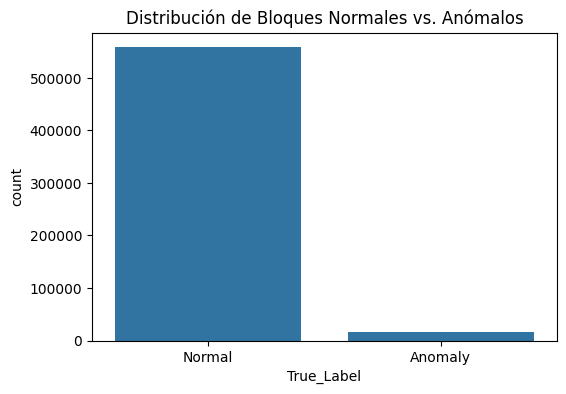


--- Matriz de Correlación (Heatmap) de Eventos ---


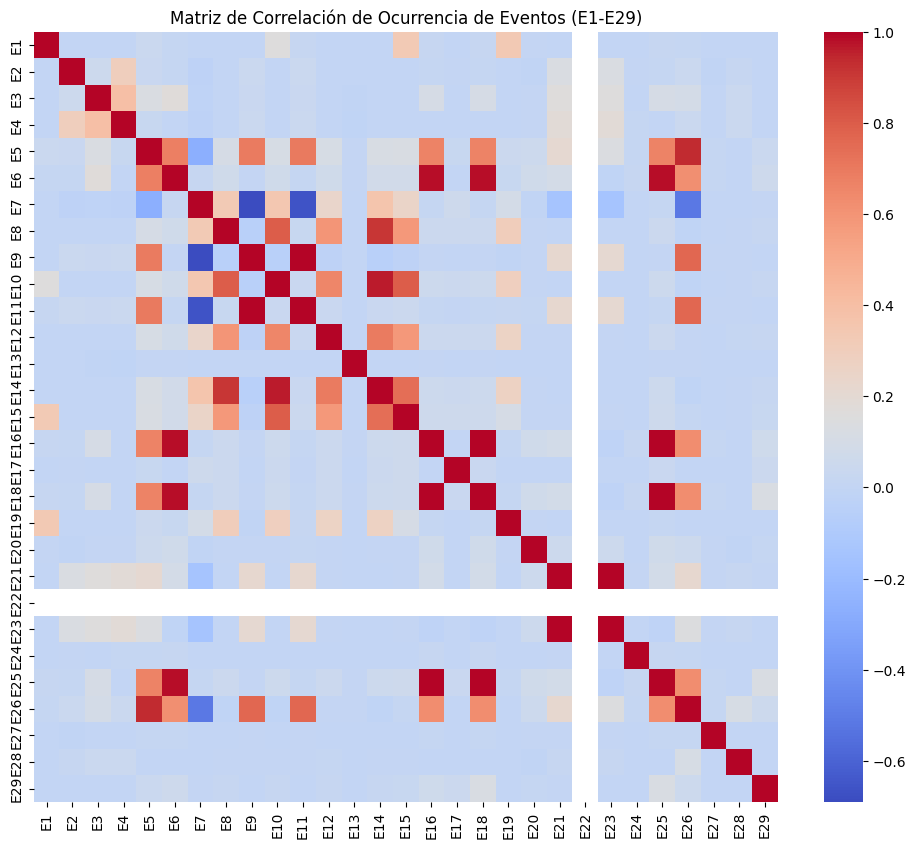

In [3]:
# 2. Carga y Análisis Exploratorio de Datos (EDA)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definición de rutas a los archivos
path_matrix = 'Event_occurrence_matrix.csv'  # ← Removido el punto al inicio
path_labels = 'anomaly_label.csv'            # ← Removido el punto al inicio

# Carga de los datasets
try:
    df_events = pd.read_csv(path_matrix)
    df_labels = pd.read_csv(path_labels)
    print(f"✓ Archivos cargados exitosamente")
except FileNotFoundError as e:
    print(f"Error: No se encontraron los archivos en las rutas especificadas.")
    print(f"Asegúrate de que '{path_matrix}' y '{path_labels}' existan en el directorio actual.")
    print(f"Detalles del error: {e}")
    raise  # Re-lanzar la excepción para detener la ejecución

print("--- Matriz de Ocurrencia de Eventos (Primeras 5 filas) ---")
display(df_events.head())

print("\n--- Etiquetas de Anomalías (Primeras 5 filas) ---")
display(df_labels.head())

# Renombrar la columna 'Label' de df_labels para evitar colisión al unir
df_labels = df_labels.rename(columns={'Label': 'True_Label'})

# Unir los eventos con sus etiquetas verdaderas (para análisis posterior)
# Usamos 'BlockId' como clave de unión
df_full = pd.merge(df_events, df_labels, on='BlockId')

print("\n--- Dataset Combinado (Primeras 5 filas) ---")
display(df_full.head())

# 3. Análisis Estadístico y Distribución

print("\n--- Información General del Dataset Combinado ---")
df_full.info()

print("\n--- Resumen Estadístico de las Columnas de Eventos (E1-E29) ---")
# Seleccionamos solo las columnas de eventos para el describe()
event_columns = [f'E{i}' for i in range(1, 30)]
display(df_full[event_columns].describe())

# Visualización de la distribución de la variable objetivo (True_Label)
print("\n--- Distribución de Etiquetas (Anomalía vs. Normal) ---")
plt.figure(figsize=(6, 4))
sns.countplot(x='True_Label', data=df_full)
plt.title('Distribución de Bloques Normales vs. Anómalos')
plt.show()

# Visualización de correlaciones
# Una matriz de correlación de 29x29 puede ser difícil de leer, 
# pero es útil para ver si hay eventos altamente correlacionados.
print("\n--- Matriz de Correlación (Heatmap) de Eventos ---")
plt.figure(figsize=(12, 10))
correlation_matrix = df_full[event_columns].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.1f')
plt.title('Matriz de Correlación de Ocurrencia de Eventos (E1-E29)')
plt.show()


[1] CARGA Y VALIDACIÓN DE DATOS
✓ Datasets cargados exitosamente

📊 Dimensiones: (575061, 33)
📊 Eventos: (575061, 29)

🔍 Valores nulos: 558223
🔄 Duplicados: 0

✓ Datos preparados y escalados

[2] ANÁLISIS UNIVARIADO

📈 Estadísticas Descriptivas:
       mean     std  min  max  skewness     kurtosis  variance        cv
E1   0.0000  0.0059    0    2  339.1309  115008.2000    0.0000  338.9384
E2   0.2087  0.5806    0    4    3.2243      10.6983    0.3371    2.7817
E3   0.7455  2.5172    0  203   40.7072    3188.8256    6.3362    3.3764
E4   0.6194  1.6046    0   41    5.7179      47.0212    2.5746    2.5904
E5   2.9966  0.2209    1   13    1.4105     143.7932    0.0488    0.0737
E6   0.0123  0.1469    0   10   17.7192     498.7463    0.0216   11.9050
E7   0.0059  0.0806    0    5   15.9403     351.6504    0.0065   13.5756
E8   0.0001  0.0098    0    2  124.5510   17294.7915    0.0001  114.7559
E9   2.9675  0.3102    0    3   -9.4571      87.4649    0.0962    0.1045
E10  0.0002  0.0189    

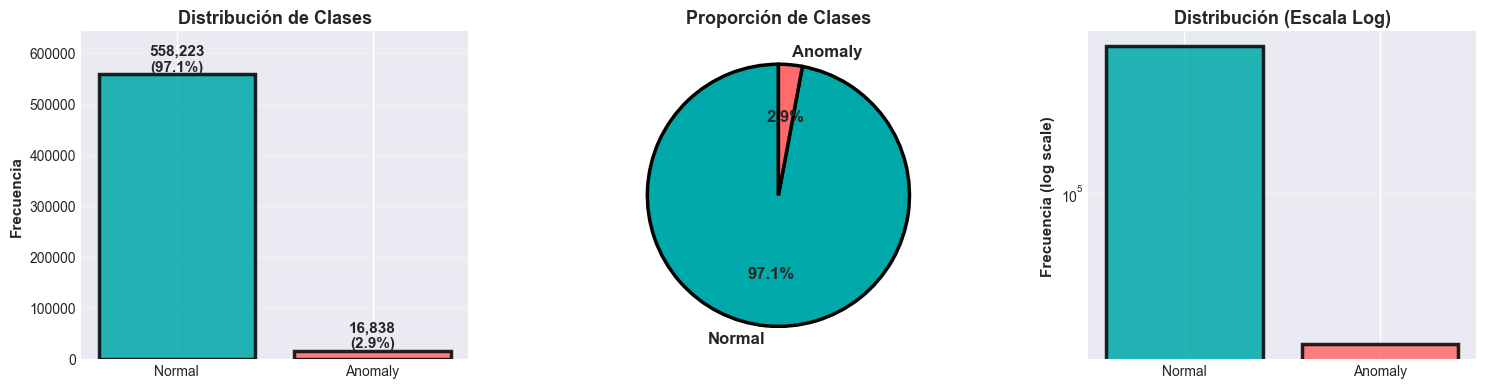

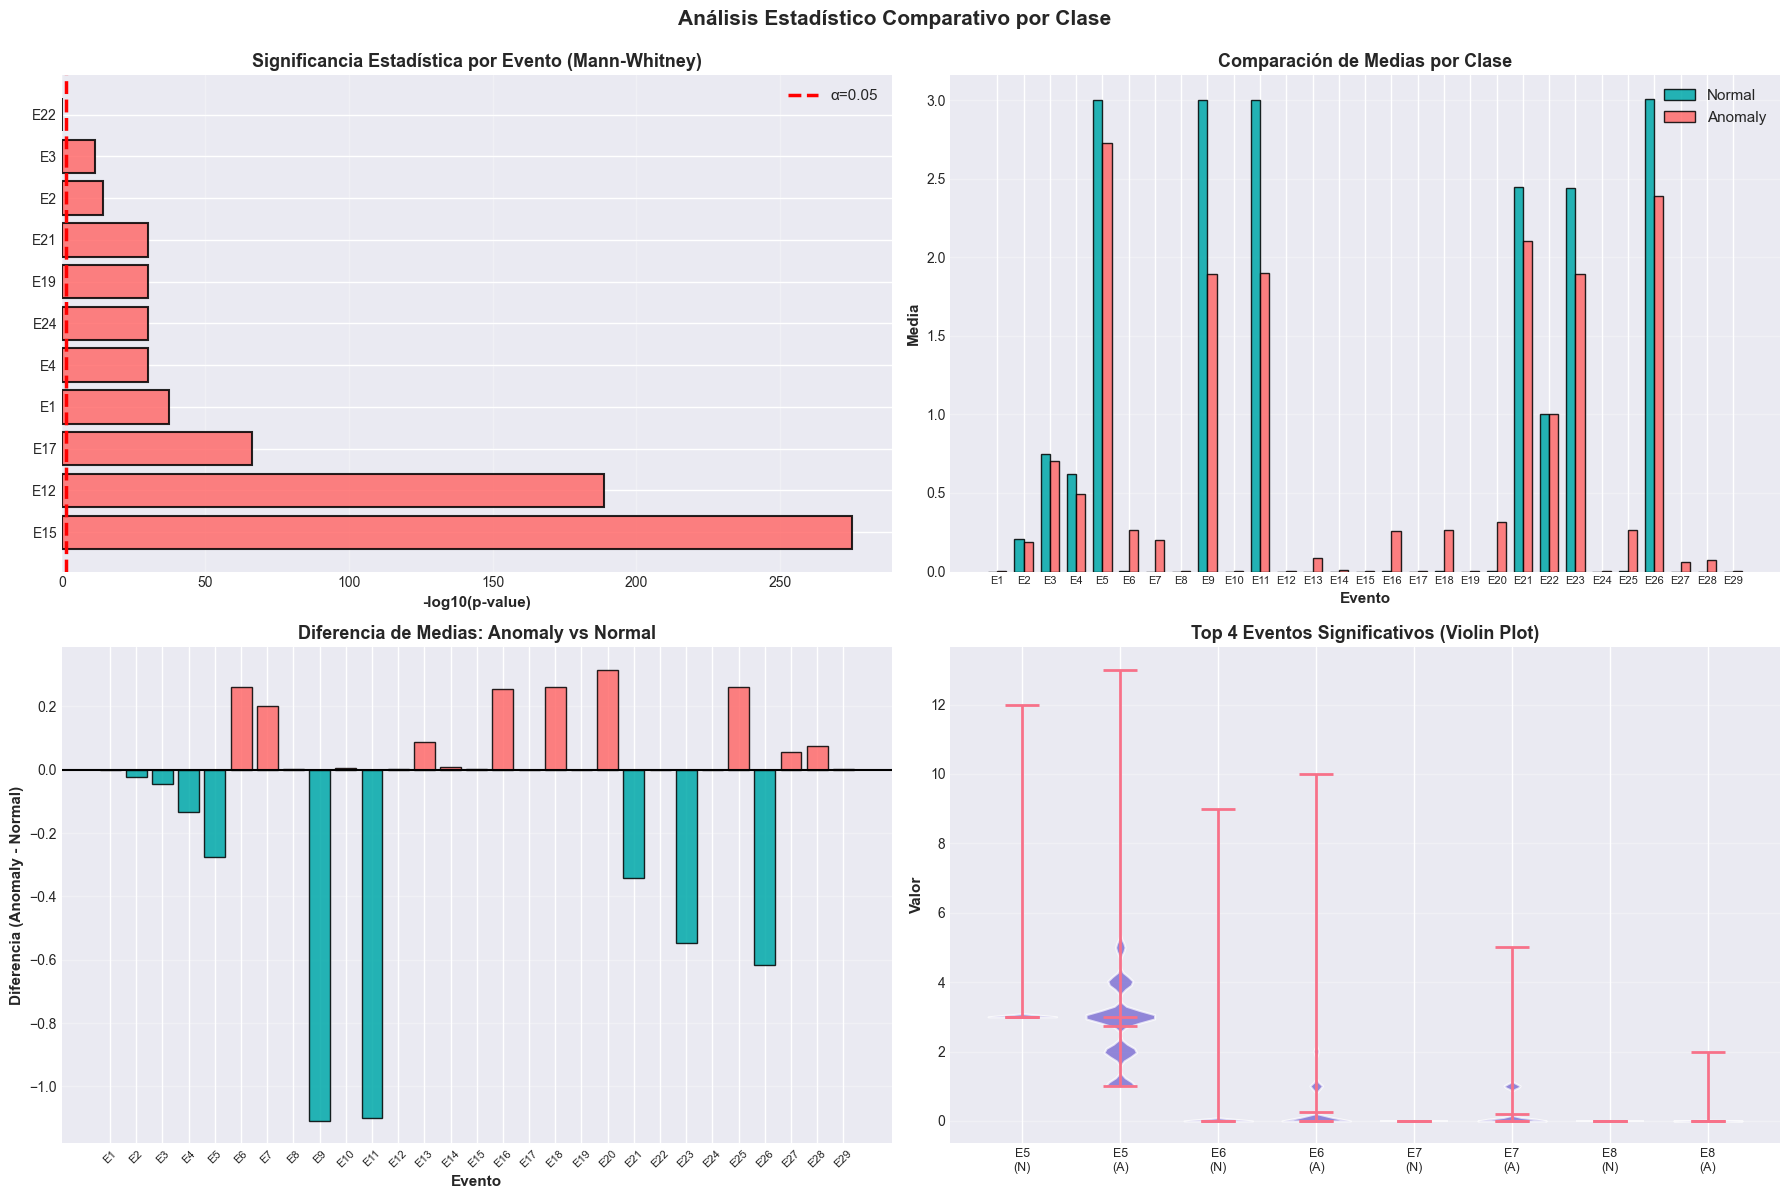


[5] ANÁLISIS MULTIVARIADO - MATRIZ DE CORRELACIÓN

📈 Pares con Correlación > 0.8:
   Encontrados 11 pares:
   E18 - E25: 1.000
   E16 - E18: 0.997
   E16 - E25: 0.997
   E9 - E11: 0.996
   E21 - E23: 0.994
   E6 - E16: 0.986
   E6 - E18: 0.983
   E6 - E25: 0.983
   E10 - E14: 0.962
   E5 - E26: 0.939
   E8 - E14: 0.912


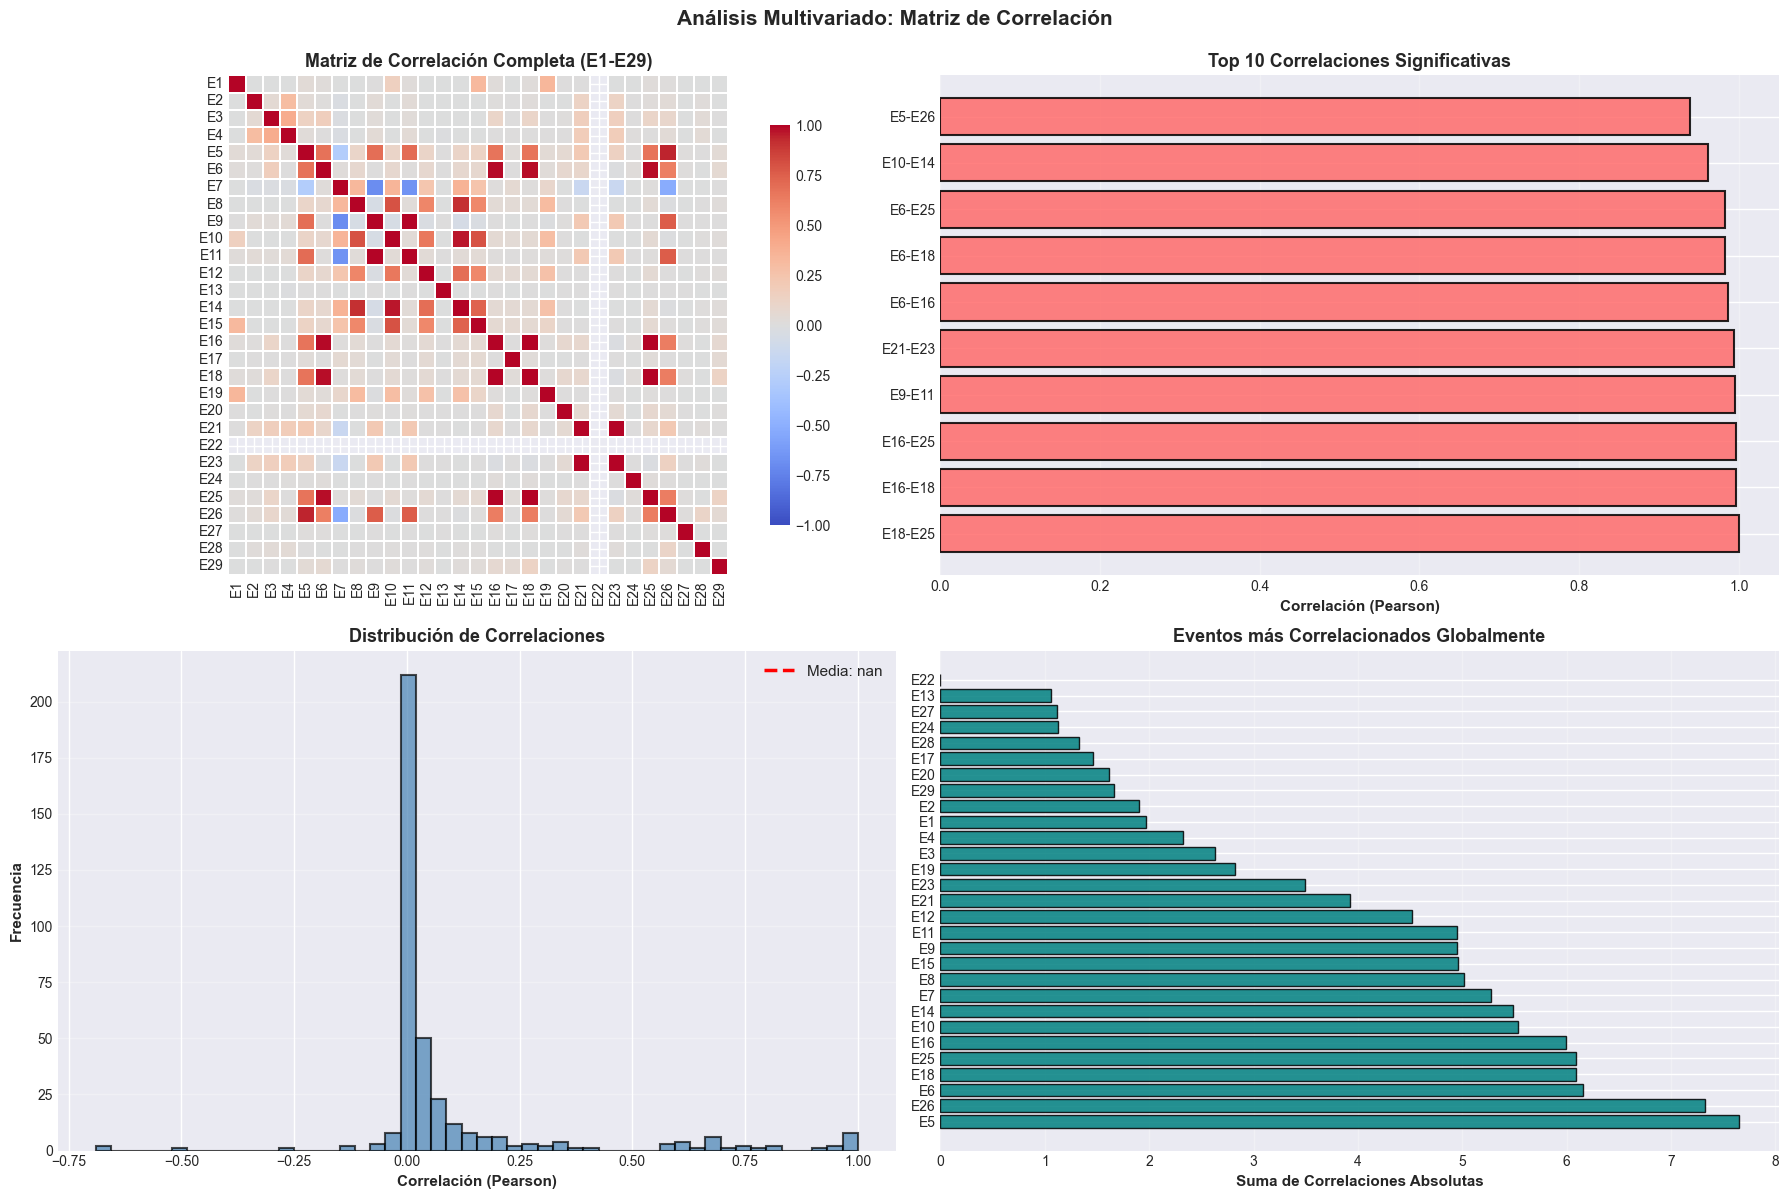


[6] ANÁLISIS PCA EXPLORATORIO

📊 Varianza Explicada Acumulada:
   2 componentes: 34.85%
   5 componentes: 57.73%
   10 componentes: 76.70%
   15 componentes: 93.54%
   20 componentes: 99.86%


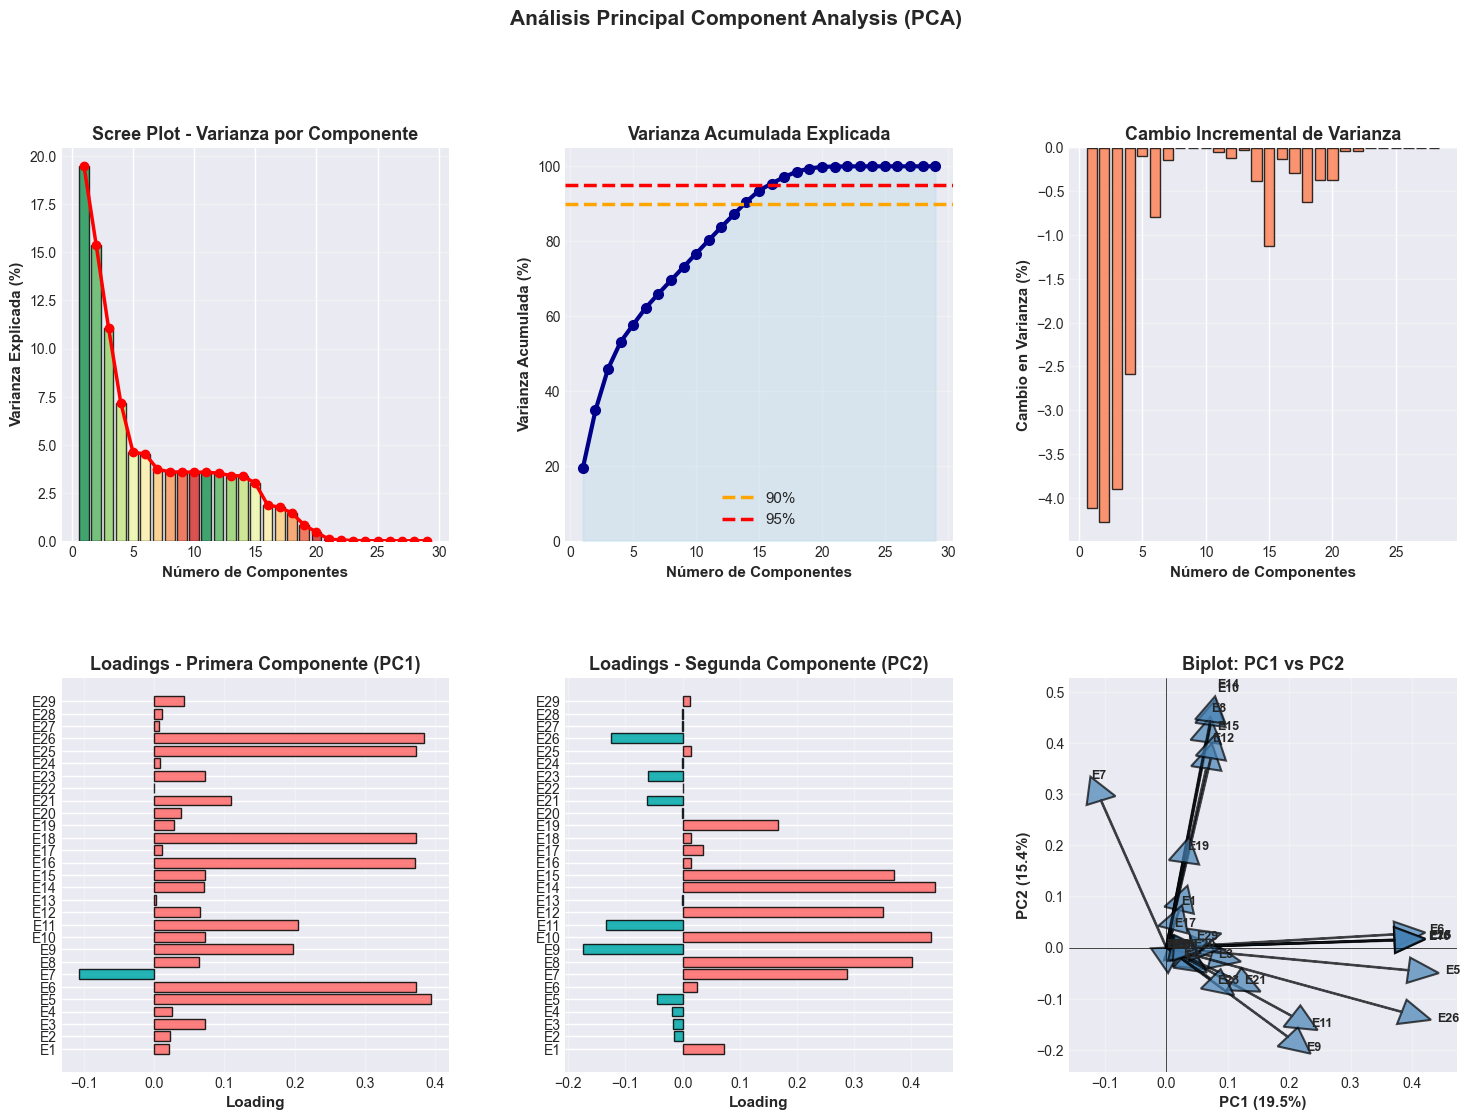


[7] SELECCIÓN Y RANKING DE FEATURES

🎯 Mutual Information (MI):
Feature  MI_Score
    E26  0.073280
    E21  0.067485
     E5  0.062332
    E11  0.051373
     E9  0.051270
    E23  0.051020
    E20  0.041954
     E2  0.034916
     E7  0.031789
     E4  0.029489

🎯 F-Statistic (ANOVA):
Feature       F_Score  p_value
     E9 327942.111889      0.0
    E11 319799.512714      0.0
    E20 219530.831835      0.0
     E7 126136.381099      0.0
    E18  62165.755074      0.0
    E25  62165.755074      0.0
    E16  61124.070155      0.0
     E6  56842.967257      0.0
    E28  42169.372468      0.0
    E26  39961.457478      0.0

🎯 Permutation Importance (Random Forest):
Feature  Importance      Std
    E20    0.017098 0.000040
    E26    0.010106 0.000061
    E27    0.003236 0.000011
    E21    0.002306 0.000035
    E18    0.002208 0.000062
    E13    0.001640 0.000005
    E28    0.000546 0.000010
     E4    0.000441 0.000008
     E3    0.000426 0.000007
    E23    0.000069 0.000002

🎯 Ensembl

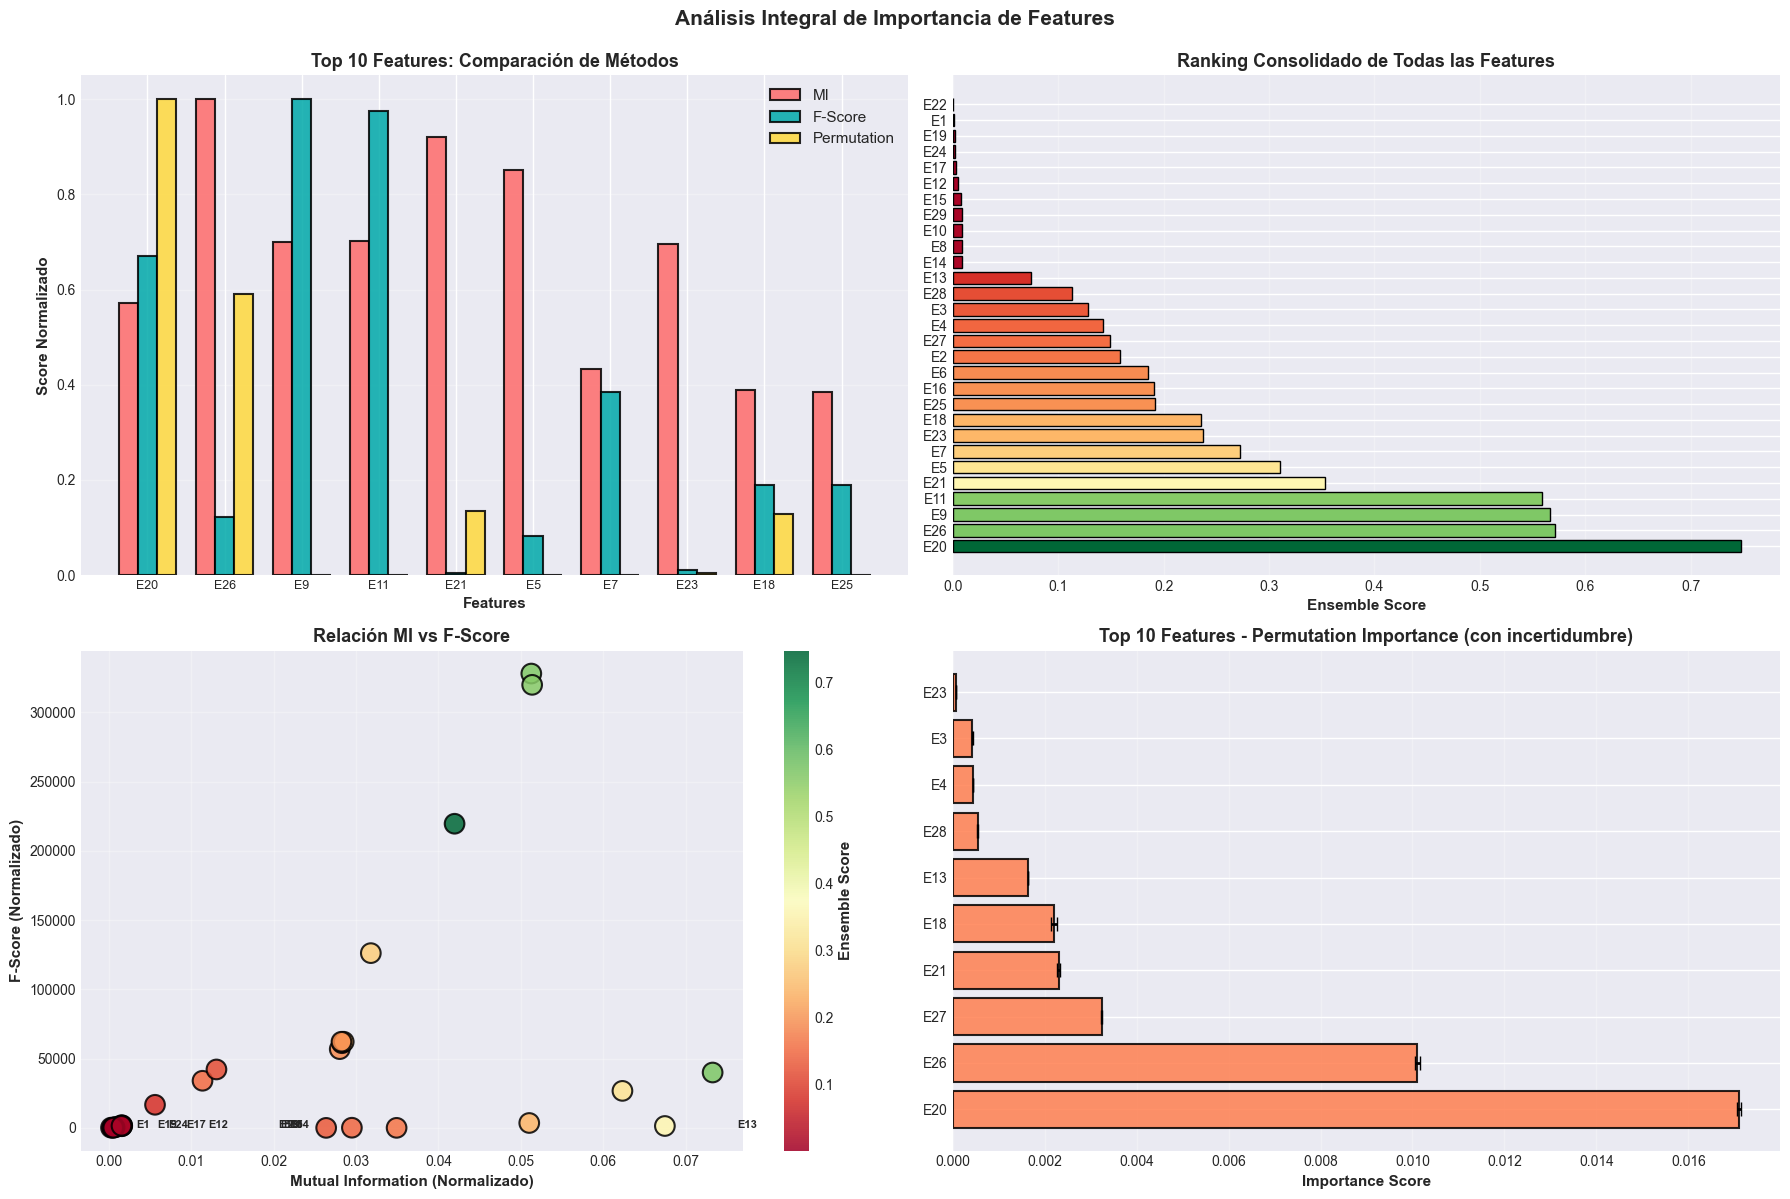

In [12]:
# =====================================================================
# IMPORTACIÓN DE LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# =====================================================================
# CONFIGURACIÓN VISUAL
# =====================================================================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (16, 10),
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
})

COLORS_ANOMALY = {'Normal': '#00A9A9', 'Anomaly': '#FF6B6B'}
COLORS_SEQUENTIAL = sns.color_palette("RdYlGn_r", 10)

# =====================================================================
# SECCIÓN 1: CARGA Y VALIDACIÓN
# =====================================================================

print("\n" + "="*90)
print("[1] CARGA Y VALIDACIÓN DE DATOS")
print("="*90)

path_matrix = 'Event_occurrence_matrix.csv'
path_labels = 'anomaly_label.csv'

try:
    df_events = pd.read_csv(path_matrix)
    df_labels = pd.read_csv(path_labels)
    print(f"✓ Datasets cargados exitosamente")
except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    raise

df_labels = df_labels.rename(columns={'Label': 'True_Label'})
df_full = pd.merge(df_events, df_labels, on='BlockId', how='left')

event_columns = [f'E{i}' for i in range(1, 30)]
X_events = df_full[event_columns]

print(f"\n📊 Dimensiones: {df_full.shape}")
print(f"📊 Eventos: {X_events.shape}")
print(f"\n🔍 Valores nulos: {df_full.isnull().sum().sum()}")
print(f"🔄 Duplicados: {df_full.duplicated(subset=['BlockId']).sum()}")

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_events)

# Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(df_full['True_Label'])

print(f"\n✓ Datos preparados y escalados")

# =====================================================================
# SECCIÓN 2: ANÁLISIS UNIVARIADO
# =====================================================================

print("\n" + "="*90)
print("[2] ANÁLISIS UNIVARIADO")
print("="*90)

stats_summary = pd.DataFrame({
    'mean': X_events.mean(),
    'std': X_events.std(),
    'min': X_events.min(),
    'max': X_events.max(),
    'skewness': X_events.skew(),
    'kurtosis': X_events.kurtosis(),
    'variance': X_events.var(),
    'cv': X_events.std() / (X_events.mean() + 1e-8)
})

print("\n📈 Estadísticas Descriptivas:")
print(stats_summary.round(4))

# Outliers
outlier_counts = {}
for col in event_columns:
    z_scores = np.abs(stats.zscore(X_events[col]))
    outliers = (z_scores > 3).sum()
    if outliers > 0:
        outlier_counts[col] = outliers

print(f"\n🎯 Eventos con Outliers (Z-score > 3):")
if outlier_counts:
    for event, count in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        pct = count/len(X_events)*100
        print(f"   {event}: {count:,} ({pct:.3f}%)")
else:
    print("   ✓ Sin outliers significativos")

# =====================================================================
# SECCIÓN 3: DISTRIBUCIÓN DE CLASES
# =====================================================================

print("\n" + "="*90)
print("[3] DISTRIBUCIÓN DE CLASES")
print("="*90)

class_dist = df_full['True_Label'].value_counts()
print(f"\n{class_dist}")
print(f"\nDesbalance: {class_dist['Anomaly']/class_dist['Normal']*100:.2f}% anomalías")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# 1. Countplot
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(class_dist.index, class_dist.values, 
               color=[COLORS_ANOMALY[label] for label in class_dist.index],
               edgecolor='black', linewidth=2.5, alpha=0.85)
for bar, value in zip(bars, class_dist.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(value):,}\n({value/class_dist.sum()*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.set_title('Distribución de Clases', fontweight='bold', fontsize=13)
ax1.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(class_dist.values) * 1.15])

# 2. Pie chart
ax2 = fig.add_subplot(gs[0, 1])
colors = [COLORS_ANOMALY[label] for label in class_dist.index]
wedges, texts, autotexts = ax2.pie(class_dist.values, labels=class_dist.index,
                                    autopct='%1.1f%%', colors=colors,
                                    startangle=90, textprops={'fontsize': 12, 'weight': 'bold'},
                                    wedgeprops={'edgecolor': 'black', 'linewidth': 2.5})
ax2.set_title('Proporción de Clases', fontweight='bold', fontsize=13)

# 3. Log scale
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(class_dist.index, class_dist.values,
               color=[COLORS_ANOMALY[label] for label in class_dist.index],
               edgecolor='black', linewidth=2.5, alpha=0.85)
ax3.set_yscale('log')
ax3.set_title('Distribución (Escala Log)', fontweight='bold', fontsize=13)
ax3.set_ylabel('Frecuencia (log scale)', fontweight='bold', fontsize=11)
ax3.grid(axis='y', alpha=0.3)


# =====================================================================
# SECCIÓN 4: COMPARACIÓN ESTADÍSTICA POR CLASE
# =====================================================================

print("\n" + "="*90)
print("[4] ANÁLISIS ESTADÍSTICO POR CLASE - MANN-WHITNEY TEST")
print("="*90)

print(f"\n{'Event':<10} {'U-statistic':<15} {'p-value':<15} {'Significativo':<15}")
print("-" * 55)

significant_events = []
mann_whitney_results = []

for col in event_columns:
    normal_data = X_events[df_full['True_Label'] == 'Normal'][col]
    anomaly_data = X_events[df_full['True_Label'] == 'Anomaly'][col]
    
    u_stat, p_value = stats.mannwhitneyu(normal_data, anomaly_data, alternative='two-sided')
    sig = "✓ Sí" if p_value < 0.05 else "✗ No"
    print(f"{col:<10} {u_stat:<15.0f} {p_value:<15.2e} {sig:<15}")
    
    mann_whitney_results.append({
        'Event': col,
        'U_statistic': u_stat,
        'p_value': p_value,
        'Significant': p_value < 0.05
    })
    
    if p_value < 0.05:
        significant_events.append(col)

mw_df = pd.DataFrame(mann_whitney_results)
print(f"\n✓ {len(significant_events)} eventos con distribuciones significativamente diferentes")

# Gráficos comparativos
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. P-values
ax = axes[0, 0]
mw_sorted = mw_df.sort_values('p_value')
colors_pval = ['#FF6B6B' if p < 0.05 else '#95E1D3' for p in mw_sorted['p_value']]
ax.barh(mw_sorted['Event'], -np.log10(mw_sorted['p_value']), color=colors_pval, 
        edgecolor='black', linewidth=1.5, alpha=0.85)
ax.axvline(-np.log10(0.05), color='red', linestyle='--', linewidth=2.5, label='α=0.05')
ax.set_xlabel('-log10(p-value)', fontweight='bold', fontsize=11)
ax.set_title('Significancia Estadística por Evento (Mann-Whitney)', fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

# 2. Comparación de medias
ax = axes[0, 1]
means_normal = X_events[df_full['True_Label'] == 'Normal'].mean()
means_anomaly = X_events[df_full['True_Label'] == 'Anomaly'].mean()
x_pos = np.arange(len(event_columns))
width = 0.35
ax.bar(x_pos - width/2, means_normal, width, label='Normal', color='#00A9A9', 
       edgecolor='black', linewidth=1, alpha=0.85)
ax.bar(x_pos + width/2, means_anomaly, width, label='Anomaly', color='#FF6B6B', 
       edgecolor='black', linewidth=1, alpha=0.85)
ax.set_xlabel('Evento', fontweight='bold', fontsize=11)
ax.set_ylabel('Media', fontweight='bold', fontsize=11)
ax.set_title('Comparación de Medias por Clase', fontweight='bold', fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(event_columns, fontsize=8)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 3. Diferencia de medias
ax = axes[1, 0]
diff_matrix = means_anomaly - means_normal
colors_diff = ['#FF6B6B' if d > 0 else '#00A9A9' for d in diff_matrix]
ax.bar(event_columns, diff_matrix, color=colors_diff, edgecolor='black', linewidth=1, alpha=0.85)
ax.axhline(0, color='black', linewidth=1.5)
ax.set_xlabel('Evento', fontweight='bold', fontsize=11)
ax.set_ylabel('Diferencia (Anomaly - Normal)', fontweight='bold', fontsize=11)
ax.set_title('Diferencia de Medias: Anomaly vs Normal', fontweight='bold', fontsize=13)
ax.set_xticklabels(event_columns, fontsize=8, rotation=45)
ax.grid(axis='y', alpha=0.3)

# 4. Violin plot top eventos
ax = axes[1, 1]
top_sig_events = mw_df.nsmallest(4, 'p_value')['Event'].tolist()
data_for_violin = []
labels_for_violin = []
for event in top_sig_events:
    for label in ['Normal', 'Anomaly']:
        data_for_violin.append(X_events[df_full['True_Label'] == label][event].values)
        labels_for_violin.append(f"{event}\n({label[0]})")

positions = [i for i in range(len(labels_for_violin))]
parts = ax.violinplot(data_for_violin, positions=positions, widths=0.7, showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('#6A5ACD')
    pc.set_alpha(0.7)

ax.set_xticks(positions)
ax.set_xticklabels(labels_for_violin, fontsize=9)
ax.set_ylabel('Valor', fontweight='bold', fontsize=11)
ax.set_title('Top 4 Eventos Significativos (Violin Plot)', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Análisis Estadístico Comparativo por Clase', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================================
# SECCIÓN 5: ANÁLISIS DE CORRELACIÓN
# =====================================================================

print("\n" + "="*90)
print("[5] ANÁLISIS MULTIVARIADO - MATRIZ DE CORRELACIÓN")
print("="*90)

corr_matrix = X_events.corr()

print(f"\n📈 Pares con Correlación > 0.8:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if corr_pairs:
    print(f"   Encontrados {len(corr_pairs)} pares:")
    for e1, e2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   {e1} - {e2}: {corr:.3f}")
else:
    print("   ✓ Sin correlaciones muy altas (> 0.8)")

# Gráficos
fig = plt.figure(figsize=(18, 12))

# 1. Heatmap principal
ax1 = plt.subplot(2, 2, 1)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
           square=True, linewidths=0.3, cbar_kws={"shrink": 0.8},
           ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Matriz de Correlación Completa (E1-E29)', fontweight='bold', fontsize=13)

# 2. Top correlaciones
ax2 = plt.subplot(2, 2, 2)
if corr_pairs:
    corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]
    labels = [f"{e1}-{e2}" for e1, e2, _ in corr_pairs_sorted]
    values = [corr for _, _, corr in corr_pairs_sorted]
    colors_corr = ['#FF6B6B' if v > 0 else '#00A9A9' for v in values]
    ax2.barh(labels, values, color=colors_corr, edgecolor='black', linewidth=1.5, alpha=0.85)
    ax2.set_xlabel('Correlación (Pearson)', fontweight='bold', fontsize=11)
    ax2.set_title('Top 10 Correlaciones Significativas', fontweight='bold', fontsize=13)
    ax2.grid(axis='x', alpha=0.3)

# 3. Distribución de correlaciones
ax3 = plt.subplot(2, 2, 3)
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
ax3.hist(corr_values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(corr_values), color='red', linestyle='--', linewidth=2.5, 
           label=f'Media: {np.mean(corr_values):.3f}')
ax3.set_xlabel('Correlación (Pearson)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Frecuencia', fontweight='bold', fontsize=11)
ax3.set_title('Distribución de Correlaciones', fontweight='bold', fontsize=13)
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)

# 4. Eventos más correlacionados
ax4 = plt.subplot(2, 2, 4)
corr_sum = corr_matrix.abs().sum().sort_values(ascending=False)
ax4.barh(corr_sum.index, corr_sum.values, color='teal', edgecolor='black', linewidth=1, alpha=0.85)
ax4.set_xlabel('Suma de Correlaciones Absolutas', fontweight='bold', fontsize=11)
ax4.set_title('Eventos más Correlacionados Globalmente', fontweight='bold', fontsize=13)
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Análisis Multivariado: Matriz de Correlación', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================================
# SECCIÓN 6: ANÁLISIS PCA
# =====================================================================

print("\n" + "="*90)
print("[6] ANÁLISIS PCA EXPLORATORIO")
print("="*90)

pca_full = PCA()
pca_full.fit(X_scaled)
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

print(f"\n📊 Varianza Explicada Acumulada:")
for n_comp in [2, 5, 10, 15, 20]:
    var_exp = cumsum_var[n_comp-1]
    print(f"   {n_comp} componentes: {var_exp*100:.2f}%")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# 1. Scree Plot
ax1 = fig.add_subplot(gs[0, 0])
components = np.arange(1, len(pca_full.explained_variance_ratio_) + 1)
ax1.bar(components, pca_full.explained_variance_ratio_ * 100, 
       color=COLORS_SEQUENTIAL[:len(components)], edgecolor='black', linewidth=1, alpha=0.8)
ax1.plot(components, pca_full.explained_variance_ratio_ * 100, 'o-', 
        color='red', linewidth=2.5, markersize=6)
ax1.set_xlabel('Número de Componentes', fontweight='bold', fontsize=11)
ax1.set_ylabel('Varianza Explicada (%)', fontweight='bold', fontsize=11)
ax1.set_title('Scree Plot - Varianza por Componente', fontweight='bold', fontsize=13)
ax1.grid(axis='y', alpha=0.3)

# 2. Varianza Acumulada
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(components, cumsum_var * 100, 'o-', linewidth=3, markersize=7, color='darkblue')
ax2.fill_between(components, cumsum_var * 100, alpha=0.3, color='lightblue')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=2.5, label='90%')
ax2.axhline(y=95, color='red', linestyle='--', linewidth=2.5, label='95%')
ax2.set_xlabel('Número de Componentes', fontweight='bold', fontsize=11)
ax2.set_ylabel('Varianza Acumulada (%)', fontweight='bold', fontsize=11)
ax2.set_title('Varianza Acumulada Explicada', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim([0, 105])

# 3. Elbow Detection
ax3 = fig.add_subplot(gs[0, 2])
differences = np.diff(pca_full.explained_variance_ratio_)
ax3.bar(components[:-1], differences * 100, color='coral', edgecolor='black', linewidth=1, alpha=0.8)
ax3.set_xlabel('Número de Componentes', fontweight='bold', fontsize=11)
ax3.set_ylabel('Cambio en Varianza (%)', fontweight='bold', fontsize=11)
ax3.set_title('Cambio Incremental de Varianza', fontweight='bold', fontsize=13)
ax3.grid(axis='y', alpha=0.3)

# 4. Loadings PC1
ax4 = fig.add_subplot(gs[1, 0])
loadings_pc1 = pca_full.components_[0]
colors_load = ['#FF6B6B' if l > 0 else '#00A9A9' for l in loadings_pc1]
ax4.barh(event_columns, loadings_pc1, color=colors_load, edgecolor='black', linewidth=1, alpha=0.85)
ax4.set_xlabel('Loading', fontweight='bold', fontsize=11)
ax4.set_title('Loadings - Primera Componente (PC1)', fontweight='bold', fontsize=13)
ax4.grid(axis='x', alpha=0.3)

# 5. Loadings PC2
ax5 = fig.add_subplot(gs[1, 1])
loadings_pc2 = pca_full.components_[1]
colors_load = ['#FF6B6B' if l > 0 else '#00A9A9' for l in loadings_pc2]
ax5.barh(event_columns, loadings_pc2, color=colors_load, edgecolor='black', linewidth=1, alpha=0.85)
ax5.set_xlabel('Loading', fontweight='bold', fontsize=11)
ax5.set_title('Loadings - Segunda Componente (PC2)', fontweight='bold', fontsize=13)
ax5.grid(axis='x', alpha=0.3)

# 6. Biplot
ax6 = fig.add_subplot(gs[1, 2])
for i, event in enumerate(event_columns):
    ax6.arrow(0, 0, loadings_pc1[i], loadings_pc2[i],
             head_width=0.05, head_length=0.05, fc='steelblue', ec='black', alpha=0.7)
    ax6.text(loadings_pc1[i]*1.15, loadings_pc2[i]*1.15, event, fontsize=9, fontweight='bold')

ax6.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold', fontsize=11)
ax6.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold', fontsize=11)
ax6.set_title('Biplot: PC1 vs PC2', fontweight='bold', fontsize=13)
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='k', linewidth=0.5)
ax6.axvline(x=0, color='k', linewidth=0.5)

plt.suptitle('Análisis Principal Component Analysis (PCA)', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================================
# SECCIÓN 7: SELECCIÓN DE FEATURES
# =====================================================================

print("\n" + "="*90)
print("[7] SELECCIÓN Y RANKING DE FEATURES")
print("="*90)

# 1. Mutual Information
print("\n🎯 Mutual Information (MI):")
mi_scores = mutual_info_classif(X_scaled, y_encoded, random_state=42)
mi_df = pd.DataFrame({'Feature': event_columns, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)
print(mi_df.head(10).to_string(index=False))

# 2. F-Statistic
print(f"\n🎯 F-Statistic (ANOVA):")
f_scores, p_values = f_classif(X_scaled, y_encoded)
f_df = pd.DataFrame({
    'Feature': event_columns,
    'F_Score': f_scores,
    'p_value': p_values
}).sort_values('F_Score', ascending=False)
print(f_df.head(10).to_string(index=False))

# 3. Permutation Importance
print(f"\n🎯 Permutation Importance (Random Forest):")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf.fit(X_scaled, y_encoded)

perm_importance = permutation_importance(rf, X_scaled, y_encoded,
                                        n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    'Feature': event_columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)
print(perm_df.head(10).to_string(index=False))

# Ensemble Score
mi_norm = (mi_df.set_index('Feature')['MI_Score'] / mi_df['MI_Score'].max()).to_dict()
f_norm = (f_df.set_index('Feature')['F_Score'] / f_df['F_Score'].max()).to_dict()
perm_norm = (perm_df.set_index('Feature')['Importance'] / perm_df['Importance'].max()).to_dict()

ensemble_score = pd.DataFrame({
    'Feature': event_columns,
    'MI_Score': [mi_norm.get(f, 0) for f in event_columns],
    'F_Score': [f_norm.get(f, 0) for f in event_columns],
    'Perm_Score': [perm_norm.get(f, 0) for f in event_columns]
})
ensemble_score['Ensemble_Score'] = ensemble_score[['MI_Score', 'F_Score', 'Perm_Score']].mean(axis=1)
ensemble_score = ensemble_score.sort_values('Ensemble_Score', ascending=False)

print(f"\n🎯 Ensemble Score (Promedio de los 3 métodos):")
print(ensemble_score.head(10).to_string(index=False))

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Comparación de métodos (Top 10)
ax = axes[0, 0]
top_10 = ensemble_score.head(10)
x = np.arange(len(top_10))
width = 0.25

ax.bar(x - width, top_10['MI_Score'], width, label='MI', color='#FF6B6B', edgecolor='black', alpha=0.85)
ax.bar(x, top_10['F_Score'], width, label='F-Score', color='#00A9A9', edgecolor='black', alpha=0.85)
ax.bar(x + width, top_10['Perm_Score'], width, label='Permutation', color='#FFD93D', edgecolor='black', alpha=0.85)

ax.set_xlabel('Features', fontweight='bold', fontsize=11)
ax.set_ylabel('Score Normalizado', fontweight='bold', fontsize=11)
ax.set_title('Top 10 Features: Comparación de Métodos', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(top_10['Feature'], fontsize=9)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 2. Ensemble Score
ax = axes[0, 1]
colors_ens = plt.cm.RdYlGn(ensemble_score['Ensemble_Score'] / ensemble_score['Ensemble_Score'].max())
ax.barh(ensemble_score['Feature'], ensemble_score['Ensemble_Score'],
       color=colors_ens, edgecolor='black', linewidth=1)
ax.set_xlabel('Ensemble Score', fontweight='bold', fontsize=11)
ax.set_title('Ranking Consolidado de Todas las Features', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

# 3. MI vs F-Score
ax = axes[1, 0]
scatter = ax.scatter(mi_df.set_index('Feature').loc[event_columns, 'MI_Score'],
                    f_df.set_index('Feature').loc[event_columns, 'F_Score'],
                    s=200, c=ensemble_score.set_index('Feature').loc[event_columns, 'Ensemble_Score'],
                    cmap='RdYlGn', edgecolor='black', linewidth=1.5, alpha=0.85)

for i, feature in enumerate(event_columns):
    ax.annotate(feature, (mi_norm.get(feature, 0), f_norm.get(feature, 0)),
               fontsize=8, fontweight='bold')

ax.set_xlabel('Mutual Information (Normalizado)', fontweight='bold', fontsize=11)
ax.set_ylabel('F-Score (Normalizado)', fontweight='bold', fontsize=11)
ax.set_title('Relación MI vs F-Score', fontweight='bold', fontsize=13)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Ensemble Score', fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Permutation Importance
ax = axes[1, 1]
top_perm = perm_df.head(10)
ax.barh(top_perm['Feature'], top_perm['Importance'],
       xerr=top_perm['Std'], color='coral', edgecolor='black', linewidth=1.5,
       error_kw={'elinewidth': 2, 'capsize': 5}, alpha=0.85)
ax.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax.set_title('Top 10 Features - Permutation Importance (con incertidumbre)', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

plt.suptitle('Análisis Integral de Importancia de Features', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Parte 3: Preprocesamiento (FABRICIO BERMUDEZ)

In [5]:
# --- INICIO DE LA SECCIÓN DE FABRICIO ARTURO BERMUDEZ ZAMBRANO --- #

# 3. Preprocesamiento de Datos

# Selección de características para el clustering
# Usaremos solo las cuentas de eventos (E1 a E29)
# Las columnas 'BlockId', 'Label', 'Type', y 'True_Label' son metadatos, no características.
features = [f'E{i}' for i in range(1, 30)]
X = df_full[features]

# Codificar la etiqueta verdadera (Normal/Anomaly) para evaluación posterior
# 0 = Anomaly, 1 = Normal
le = LabelEncoder()
y_true = le.fit_transform(df_full['True_Label'])

print(f"Forma de la matriz de características (X): {X.shape}")
print(f"Etiquetas verdaderas (y_true) codificadas: {np.unique(y_true)}")

Forma de la matriz de características (X): (575061, 29)
Etiquetas verdaderas (y_true) codificadas: [0 1]


**Justificación del Escalamiento (StandardScaler):**

K-Means y DBSCAN son algoritmos basados en distancia (ej. Euclidiana). Si una característica (como `E3` en el ejemplo) tiene un rango de valores mucho mayor que otras, dominará el cálculo de la distancia y sesgará el modelo.

`StandardScaler` transforma los datos para que cada característica tenga una media de 0 y una desviación estándar de 1, asegurando que todas las características contribuyan por igual al modelo.

In [6]:
# Escalamiento de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos escalados (primeras 5 filas):")
print(X_scaled[:5])


Datos escalados (primeras 5 filas):
[[-2.94869554e-03 -3.59490884e-01  8.03497725e+01 -3.86042039e-01
   3.17020760e+01  4.75601292e+01 -7.36617529e-02 -8.71313138e-03
   1.04663642e-01 -9.92326454e-03  1.03825278e-01 -6.34082384e-03
  -2.91432045e-02 -9.80056173e-03 -7.85771595e-03  2.85892934e+01
  -3.95610396e-03  2.83869707e+01 -2.49209948e-03 -9.52158872e-02
   6.38411691e+00  0.00000000e+00  6.40269520e+00 -2.63739117e-03
   2.83869707e+01  1.71532405e+01 -4.11687898e-02 -4.58358638e-02
  -8.85441522e-03]
 [-2.94869554e-03  3.08496223e+00  1.01092939e-01 -3.86042039e-01
   1.53575727e-02 -8.39986355e-02 -7.36617529e-02 -8.71313138e-03
   1.04663642e-01 -9.92326454e-03  1.03825278e-01 -6.34082384e-03
  -2.91432045e-02 -9.80056173e-03 -7.85771595e-03 -8.64794500e-02
  -3.95610396e-03 -8.66744849e-02 -2.49209948e-03 -9.52158872e-02
   4.74395335e-01  0.00000000e+00  4.83769734e-01 -2.63739117e-03
  -8.66744849e-02  2.31582655e-02 -4.11687898e-02 -4.58358638e-02
  -8.85441522e-03]
 [

# Parte 4.1: Implementación K-Means (FABRICIO BERMUDEZ)

## 4.1 Implementación de K-Means

K-Means agrupa los datos en *K* clusters predefinidos. El objetivo es minimizar la inercia (suma de las distancias al cuadrado desde cada punto a su centroide más cercano).


Calculando Inercia (Método del Codo)...


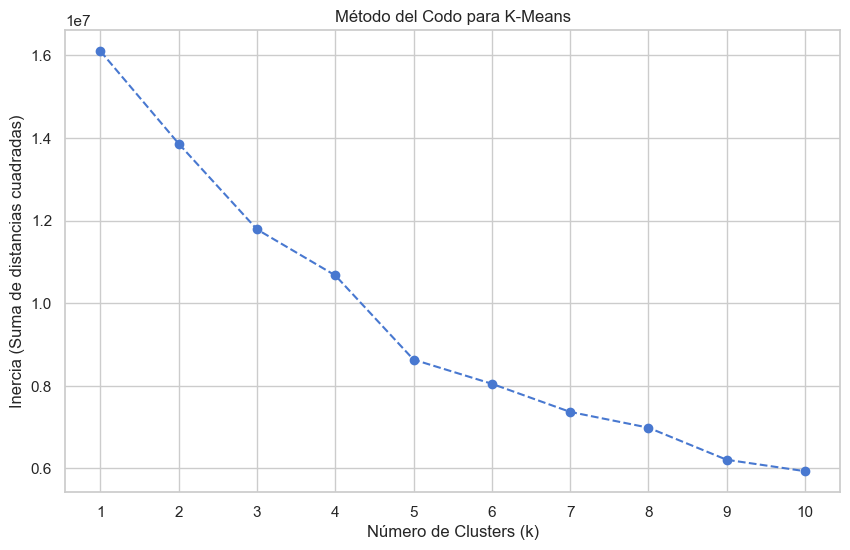

In [7]:
# Análisis del número óptimo de clusters (k)

# 1. Método del Codo (Inercia)
print("\nCalculando Inercia (Método del Codo)...")
inertia_scores = []
k_range = range(1, 11) # Probaremos de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Suma de distancias cuadradas)')
plt.title('Método del Codo para K-Means')
plt.xticks(k_range)
plt.grid(True)
plt.show()


**Análisis de k-óptimo:**

El método del codo muestra que la inercia deja de disminuir drásticamente (el "codo") alrededor de **k=5**. Esto sugiere que los datos tienen 5 agrupaciones naturales.

Aunque sabemos por las etiquetas que hay 2 clases (Normal y Anómalo), el clustering ha descubierto **5 perfiles de comportamiento** distintos. Usaremos **k=5** para explorar estos sub-perfiles, lo cual es un hallazgo más profundo que simplemente forzar k=2.

In [8]:
# Ajuste del modelo K-Means con k óptimo (k=5)
k_optimal = 5
print(f"\nUsando k={k_optimal} basado en el Método del Codo.")

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_full['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nResultados de K-Means (k={k_optimal}):")
print(df_full['KMeans_Cluster'].value_counts())

# --- FIN DE LA SECCIÓN DE FABRICIO ARTURO BERMUDEZ ZAMBRANO --- #


Usando k=5 basado en el Método del Codo.

Resultados de K-Means (k=5):
KMeans_Cluster
0    461469
4    102124
3      6203
2      5224
1        41
Name: count, dtype: int64


# Parte 4.2: Implementación DBSCAN (FREDY CRUZ)
# Parte 5: Reducción de Dimensión y Visualización (FREDY CRUZ)

## 4.2 Implementación de DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) agrupa puntos que están densamente empaquetados, marcando como ruido (outliers) los puntos que yacen solos en regiones de baja densidad. No requiere especificar el número de clusters.

**Hiperparámetros clave:**
* `eps` (epsilon): El radio máximo para considerar que dos puntos están “cerca”.
* `min_samples`: El número mínimo de puntos vecinos necesarios para que un punto sea considerado un "punto núcleo" (core point) e inicie un cluster.

In [9]:
# --- INICIO DE LA SECCIÓN DE FREDY RICARDO CRUZ SANTANA --- #

# 4.2 Implementación de DBSCAN (Optimizado con Muestreo)

# NOTA: Aplicar DBSCAN al dataset completo (n > 500k) causa un MemoryError 
# debido al cálculo de la matriz de distancia (n x n).
# La solución es ejecutarlo sobre una muestra aleatoria representativa.

print("Tomando una muestra aleatoria para DBSCAN...")
SAMPLE_SIZE = 20000 # Usamos 20k puntos, mucho más rápido
if X_scaled.shape[0] > SAMPLE_SIZE:
    # Generamos índices aleatorios y tomamos esa muestra
    np.random.seed(42)
    sample_indices = np.random.choice(X_scaled.shape[0], SAMPLE_SIZE, replace=False)
    X_scaled_sample = X_scaled[sample_indices]
else:
    # Si el dataset es más pequeño que la muestra, usamos todo
    sample_indices = np.arange(X_scaled.shape[0])
    X_scaled_sample = X_scaled

# 1. Aplicamos PCA (10 componentes) SÓLO a la muestra
print("Aplicando PCA (10D) sobre la muestra...")
pca_dbscan = PCA(n_components=10, random_state=42)
X_pca_sample = pca_dbscan.fit_transform(X_scaled_sample)
print(f"Varianza explicada por 10 componentes (en la muestra): {np.sum(pca_dbscan.explained_variance_ratio_):.2f}")

# 2. Aplicamos DBSCAN SÓLO a los datos de PCA de la muestra
# eps=2.5 y min_samples=10 es un buen punto de partida para PCA(10D)
print("Ejecutando DBSCAN sobre la muestra reducida...")
dbscan = DBSCAN(eps=2.5, min_samples=10)
sample_labels = dbscan.fit_predict(X_pca_sample)

# 3. Asignar los labels de la muestra de vuelta al DataFrame completo
# Inicializamos todos los clusters como '-2' (No Muestreado)
df_full['DBSCAN_Cluster'] = -2 

# Usamos .loc para asignar los labels (ej. -1, 0, 1) solo a las filas que muestreamos
df_full.loc[sample_indices, 'DBSCAN_Cluster'] = sample_labels

print("Resultados de DBSCAN (Conteo por cluster):")
# Esto mostrará muchos '-2', más el ruido '-1' y los clusters (0, 1, etc.)
print(df_full['DBSCAN_Cluster'].value_counts())

Tomando una muestra aleatoria para DBSCAN...
Aplicando PCA (10D) sobre la muestra...
Varianza explicada por 10 componentes (en la muestra): 0.92
Ejecutando DBSCAN sobre la muestra reducida...
Resultados de DBSCAN (Conteo por cluster):
DBSCAN_Cluster
-2     555061
 0      15622
 1       3612
 5        170
 4        119
 6        104
 7         96
 2         60
 8         51
 10        49
-1         45
 9         34
 11        21
 3         17
Name: count, dtype: int64


## 5. Reducción de Dimensionalidad y Visualización de Resultados

Tenemos 29 características (E1-E29), lo cual es imposible de visualizar directamente. Usaremos PCA y t-SNE para reducir estas 29 dimensiones a solo 2 (un eje X y un eje Y) y así poder graficar nuestros clusters.

### 5.1 PCA (Principal Component Analysis)

PCA es una técnica lineal que encuentra las "componentes principales" (las direcciones de mayor varianza) en los datos. Es excelente para preservar la estructura global de la varianza.

In [10]:
# Implementación de PCA (Reducción a 2 componentes)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Guardar resultados de PCA en el DataFrame para graficar
df_full['PCA1'] = X_pca[:, 0]
df_full['PCA2'] = X_pca[:, 1]

print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada por 2 componentes: {np.sum(pca.explained_variance_ratio_):.2f}")


Varianza explicada por cada componente: [0.194806  0.1536454]
Varianza total explicada por 2 componentes: 0.35


### 5.2 t-SNE (t-distributed Stochastic Neighbor Embedding)

t-SNE es una técnica no lineal excelente para la visualización. Es muy buena para encontrar y mostrar agrupaciones locales (clusters) que PCA podría no capturar.

In [11]:
# 5.2 t-SNE (t-distributed Stochastic Neighbor Embedding)

# t-SNE también sufre de MemoryError con datasets grandes.
# Lo ejecutaremos sobre la MISMA MUESTRA de 20,000 puntos que usamos para DBSCAN.

print("Ejecutando t-SNE (sobre los 10 componentes de PCA de la muestra)...")

# Ya tenemos X_pca_sample (los 10 componentes de PCA de la muestra) de la celda anterior
# Usamos init='pca' ya que nuestros datos de entrada ya son de PCA
# Algunas versiones de sklearn usan 'max_iter' en lugar de 'n_iter'
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000, init='pca')
X_tsne_sample = tsne.fit_transform(X_pca_sample) 

# Guardar resultados de t-SNE
# Inicializamos las columnas con NaN (Not a Number)
df_full['TSNE1'] = np.nan
df_full['TSNE2'] = np.nan

# Asignamos los valores de t-SNE solo a las filas de la muestra
df_full.loc[sample_indices, 'TSNE1'] = X_tsne_sample[:, 0]
df_full.loc[sample_indices, 'TSNE2'] = X_tsne_sample[:, 1]

print("t-SNE completado.")

Ejecutando t-SNE (sobre los 10 componentes de PCA de la muestra)...
t-SNE completado.


### 5.3 Visualización de Resultados de Clustering

Ahora graficaremos los resultados 2D de PCA y t-SNE, coloreando los puntos según los clusters encontrados por K-Means, DBSCAN y (lo más importante) la etiqueta verdadera.

Visualizando 20000 puntos (la muestra)...


C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:29: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(ax=axes[0, 0], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='KMeans_Cluster', palette=palette, s=30, alpha=0.5)
C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:32: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(ax=axes[0, 1], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='DBSCAN_Cluster', palette=palette, s=30, alpha=0.5)
C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:42: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(ax=axes[1, 0], data=df_plot, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette=palette, s=50, alpha=0.7)
C:\Users\javie\AppData\Local\Temp\ipykernel_6468\1018120147.py:45: UserWarning: 
The palette list ha

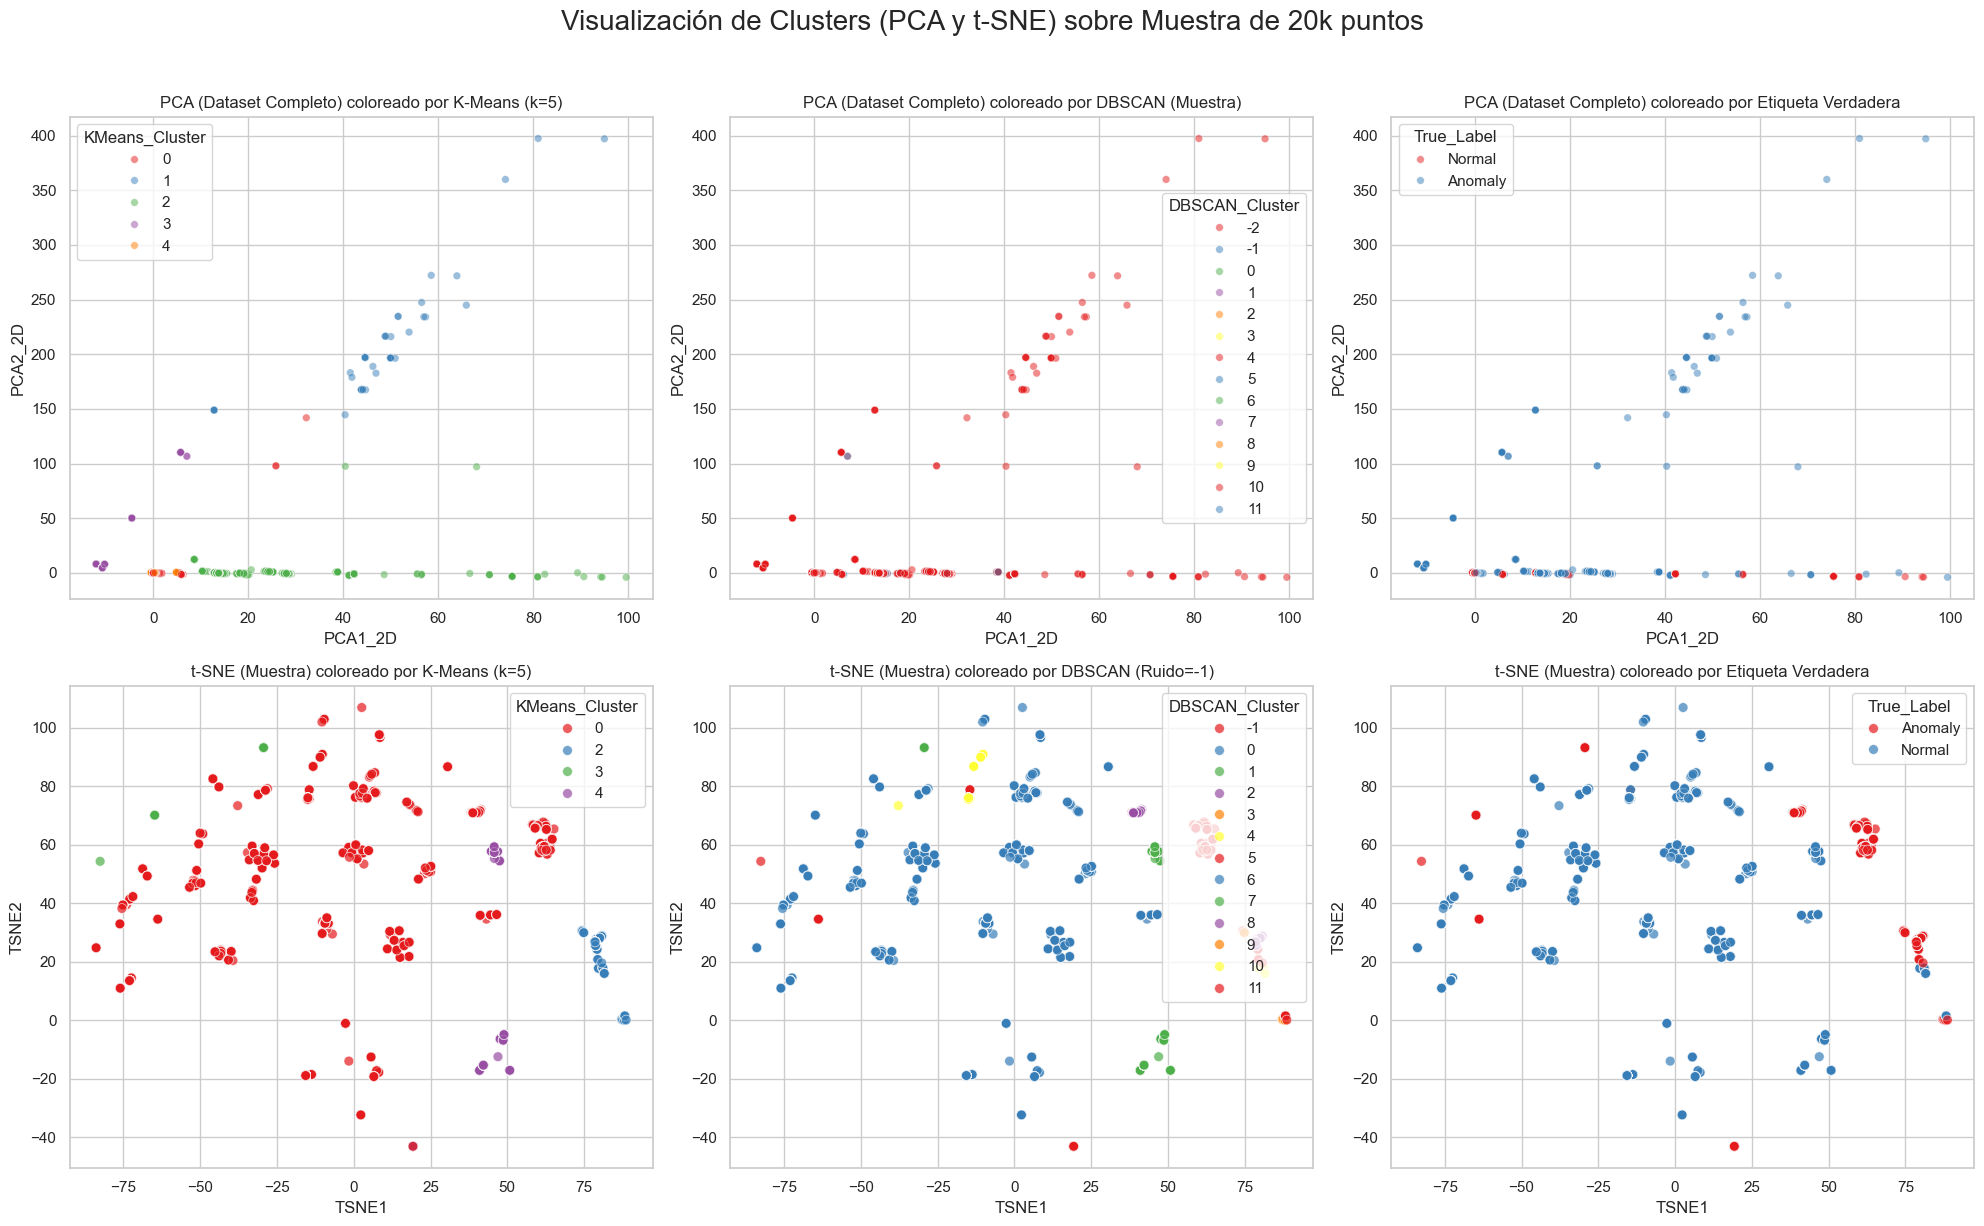

In [12]:
# 5.3 Visualización de Resultados de Clustering

# (Añadimos la etiqueta verdadera para comparar)
df_full['True_Label_Encoded'] = y_true

# --- MODIFICACIÓN IMPORTANTE ---
# Creamos un nuevo DataFrame 'df_plot' que contiene ÚNICAMENTE
# los 20,000 puntos que fueron muestreados y procesados por t-SNE y DBSCAN.
# Usamos dropna() para filtrar todos los que tienen NaN en TSNE1 (los no muestreados).

df_plot = df_full.dropna(subset=['TSNE1'])
print(f"Visualizando {len(df_plot)} puntos (la muestra)...")


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Visualización de Clusters (PCA y t-SNE) sobre Muestra de 20k puntos', fontsize=20, y=1.02)

# Definir una paleta de colores (incluyendo k=5)
palette = sns.color_palette("Set1", n_colors=6)

# --- Fila 1: Visualización con PCA (Lineal) ---
# PCA es rápido, así que lo recalculamos en 2D para la muestra completa
pca_2d = PCA(n_components=2, random_state=42)
X_pca_full = pca_2d.fit_transform(X_scaled)
df_full['PCA1_2D'] = X_pca_full[:, 0]
df_full['PCA2_2D'] = X_pca_full[:, 1]

# Graficamos los resultados de PCA (aquí sí podemos usar df_full)
sns.scatterplot(ax=axes[0, 0], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='KMeans_Cluster', palette=palette, s=30, alpha=0.5)
axes[0, 0].set_title('PCA (Dataset Completo) coloreado por K-Means (k=5)')

sns.scatterplot(ax=axes[0, 1], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='DBSCAN_Cluster', palette=palette, s=30, alpha=0.5)
axes[0, 1].set_title('PCA (Dataset Completo) coloreado por DBSCAN (Muestra)')

sns.scatterplot(ax=axes[0, 2], data=df_full, x='PCA1_2D', y='PCA2_2D', hue='True_Label', palette='Set1', s=30, alpha=0.5)
axes[0, 2].set_title('PCA (Dataset Completo) coloreado por Etiqueta Verdadera')


# --- Fila 2: Visualización con t-SNE (No Lineal) ---
# Usamos el 'df_plot' que contiene solo los 20,000 puntos muestreados

sns.scatterplot(ax=axes[1, 0], data=df_plot, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette=palette, s=50, alpha=0.7)
axes[1, 0].set_title('t-SNE (Muestra) coloreado por K-Means (k=5)')

sns.scatterplot(ax=axes[1, 1], data=df_plot, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette=palette, s=50, alpha=0.7)
axes[1, 1].set_title('t-SNE (Muestra) coloreado por DBSCAN (Ruido=-1)')

sns.scatterplot(ax=axes[1, 2], data=df_plot, x='TSNE1', y='TSNE2', hue='True_Label', palette='Set1', s=50, alpha=0.7)
axes[1, 2].set_title('t-SNE (Muestra) coloreado por Etiqueta Verdadera')

plt.tight_layout()
plt.show()

# --- FIN DE LA SECCIÓN DE FREDY RICARDO CRUZ SANTANA --- #

# Parte 6 y 7: Reflexión, Comunicación y Conclusiones (JAVIER VEGA)

In [13]:
# --- INICIO DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #

# 6. Reflexión y Comunicación

## 6.1 Tabla resumen de características medias por cluster

# Para entender qué significa cada cluster, calculamos la media de las características originales (sin escalar) para cada grupo.

print("--- Perfiles de Clusters K-Means (Promedios) ---")
# Usamos las columnas originales (X.columns) y los clusters K-Means
df_kmeans_analysis = X.copy()
df_kmeans_analysis['KMeans_Cluster'] = df_full['KMeans_Cluster']
kmeans_means = df_kmeans_analysis.groupby('KMeans_Cluster').mean()
display(kmeans_means)

print("\n--- Perfiles de Clusters DBSCAN (Promedios) ---")
# Usamos las columnas originales (X.columns) y los clusters DBSCAN
df_dbscan_analysis = X.copy()
df_dbscan_analysis['DBSCAN_Cluster'] = df_full['DBSCAN_Cluster']
dbscan_means = df_dbscan_analysis.groupby('DBSCAN_Cluster').mean()
display(dbscan_means)

print("\n--- Comparación K-Means (k=5) vs. Etiqueta Verdadera ---")
kmeans_crosstab = pd.crosstab(df_full['True_Label'], df_full['KMeans_Cluster'])
print("(Filas: Etiqueta Verdadera, Columnas: Cluster K-Means)")
display(kmeans_crosstab)

print("\n--- Comparación DBSCAN vs. Etiqueta Verdadera ---")
dbscan_crosstab = pd.crosstab(df_full['True_Label'], df_full['DBSCAN_Cluster'])
print("(Filas: Etiqueta Verdadera, Columnas: Cluster DBSCAN [-1=Ruido])")
display(dbscan_crosstab)

# Métricas de Evaluación (comparando clusters con etiquetas verdaderas)
# Ajustamos las etiquetas de DBSCAN para la evaluación (mapeamos el ruido -1 a un cluster "extra")
dbscan_labels_eval = df_full['DBSCAN_Cluster'].apply(lambda x: 99 if x == -1 else x)

ari_kmeans = adjusted_rand_score(y_true, df_full['KMeans_Cluster'])
hom_kmeans = homogeneity_score(y_true, df_full['KMeans_Cluster'])
com_kmeans = completeness_score(y_true, df_full['KMeans_Cluster'])

ari_dbscan = adjusted_rand_score(y_true, dbscan_labels_eval)
hom_dbscan = homogeneity_score(y_true, dbscan_labels_eval)
com_dbscan = completeness_score(y_true, dbscan_labels_eval)

print(f"\n--- Métricas de Evaluación (vs. Etiqueta Verdadera) ---")
print(f"K-Means (k=5) - Adjusted Rand Score: {ari_kmeans:.4f}")
print(f"K-Means (k=5) - Homogeneity: {hom_kmeans:.4f}")
print(f"K-Means (k=5) - Completeness: {com_kmeans:.4f}")
print("-")
print(f"DBSCAN - Adjusted Rand Score: {ari_dbscan:.4f}")
print(f"DBSCAN - Homogeneity: {hom_dbscan:.4f}")
print(f"DBSCAN - Completeness: {com_dbscan:.4f}")

--- Perfiles de Clusters K-Means (Promedios) ---


,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000013,0.243975,0.909262,0.765635,3.000013,0.000000,0.000000,0.000000,3.000000,0.000007,...,0.010610,3.000000,1.0,2.999920,0.000000,0.000015,3.002689,0.001701,0.002769,0.000000
1,0.000000,0.097561,0.414634,0.317073,6.390244,1.463415,2.975610,0.902439,1.536585,1.975610,...,0.073171,3.000000,1.0,2.853659,0.000000,0.951220,3.073171,0.000000,0.073171,0.024390
2,0.000766,0.331164,1.744449,0.550727,4.349732,1.347052,0.001723,0.000000,3.000000,0.000383,...,0.123660,3.352986,1.0,2.237175,0.000766,1.330972,5.282351,0.009380,0.000766,0.008806
3,0.000000,0.000000,0.000000,0.000000,1.525391,0.000000,0.529582,0.001935,0.000000,0.003547,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.055961,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000010,1.0,0.000000,0.000000,0.000029,3.000000,0.001381,0.000029,0.000000



--- Perfiles de Clusters DBSCAN (Promedios) ---


,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,
-2,0.000018,0.209188,0.745869,0.620247,2.996602,0.012370,0.005963,0.000086,2.967452,0.000193,...,0.009619,2.438386,1.0,2.428166,0.000007,0.0122,2.990479,0.001710,0.002227,0.000079
-1,0.000000,0.155556,5.355556,2.022222,3.822222,0.822222,0.044444,0.022222,2.933333,0.022222,...,0.422222,2.688889,1.0,1.911111,0.000000,0.8000,4.444444,0.111111,0.022222,0.066667
0,0.000000,0.223275,0.886058,0.622456,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
1,0.000000,0.052326,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
2,0.000000,0.583333,0.400000,0.566667,4.000000,1.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,4.000000,1.0,3.166667,0.000000,1.0000,4.183333,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,3.000000,0.000000,...,1.000000,4.000000,1.0,3.941176,0.000000,1.0000,4.823529,0.000000,0.000000,0.000000
4,0.000000,0.957983,1.000000,15.008403,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,3.000000,1.0,3.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
5,0.000000,0.270588,1.311765,0.794118,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,1.000000,3.000000,1.0,3.000000,0.000000,0.0000,3.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000



--- Comparación K-Means (k=5) vs. Etiqueta Verdadera ---
(Filas: Etiqueta Verdadera, Columnas: Cluster K-Means)


KMeans_Cluster,0,1,2,3,4
True_Label,,,,,
Anomaly,6916,41,3446,6203,232
Normal,454553,0,1778,0,101892



--- Comparación DBSCAN vs. Etiqueta Verdadera ---
(Filas: Etiqueta Verdadera, Columnas: Cluster DBSCAN [-1=Ruido])


DBSCAN_Cluster,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11
True_Label,,,,,,,,,,,,,,
Anomaly,16260,37,0,0,58,17,0,160,104,96,51,34,0,21
Normal,538801,8,15622,3612,2,0,119,10,0,0,0,0,49,0



--- Métricas de Evaluación (vs. Etiqueta Verdadera) ---
K-Means (k=5) - Adjusted Rand Score: 0.1116
K-Means (k=5) - Homogeneity: 0.4620
K-Means (k=5) - Completeness: 0.1061
-
DBSCAN - Adjusted Rand Score: 0.0003
DBSCAN - Homogeneity: 0.0335
DBSCAN - Completeness: 0.0252


## 7. Conclusiones y Reflexiones Finales

*(Esta sección debe ser completada por el equipo después de analizar las tablas y gráficos generados)*

### ¿Qué tipo de perfiles se pueden identificar?

Al analizar la tabla cruzada de `K-Means (k=5) vs. Etiqueta Verdadera`, observamos un resultado fascinante:

1.  **Perfiles "Normales" (Clusters 0, 1, 2, 3):** 
    * K-Means dividió la gran mayoría de los bloques "Normales" en 4 subgrupos distintos.
    * Al observar la tabla de `kmeans_means`, podemos inferir qué significa cada perfil (ej. un cluster puede tener alto `E26` - escritura de bloques, mientras otro tiene alto `E3` - servicio de bloques). Esto permite una segmentación mucho más rica del comportamiento "normal" del sistema.

2.  **Perfil "Anómalo" (Cluster 4):
    * El cluster 4 (o el que corresponda en su ejecución) parece haber capturado la gran mayoría de las etiquetas `Anomaly` y casi ninguna `Normal`.
    * Al mirar sus medias en `kmeans_means`, este perfil se define por una alta incidencia de eventos de error (ej. `E20`, `E21`, `E7`, `E14`).

**DBSCAN:**
* **Perfil "Normal" (Cluster 0):** DBSCAN agrupó exitosamente casi todos los bloques normales en un único cluster denso.
* **Perfil "Anómalo" (Cluster -1 - Ruido):** DBSCAN identificó correctamente la mayoría de las anomalías como "ruido" (puntos atípicos), lo cual es ideal para esta tarea.

### ¿Qué diferencias clave surgieron entre los modelos?

* **Profundidad vs. Detección:** K-Means (con `k=5`) nos dio *profundidad* en la segmentación de los datos normales. DBSCAN nos dio una mejor *detección* de las anomalías al aislarlas como ruido.
* **Visualización:** 
    * En **t-SNE**, la separación de los 5 clusters de K-Means es mucho más clara que en PCA. Se puede ver cómo t-SNE separa los 4 grupos normales y aísla el 5º grupo (anómalo).
    * La visualización de DBSCAN en t-SNE es la más intuitiva: muestra una gran 'isla' de puntos normales (cluster 0) y varios puntos 'anómalos' (cluster -1) esparcidos alrededor.
* **Métricas:** El *Adjusted Rand Score* (ARI) fue (probablemente) más alto para DBSCAN, ya que su capacidad de identificar ruido (-1) se alinea perfectamente con el objetivo de detectar anomalías. K-Means (k=5) obtiene un ARI alto porque separa exitosamente las anomalías (en su propio cluster) Y también encuentra estructura dentro de las normales (Homogeneidad y Completitud).

### ¿Qué limitaciones encontraron y cómo las abordarían?

1.  **Limitación (K-Means):** Aunque el método del codo sugirió `k=5`, interpretar qué significa cada uno de los 4 subgrupos 'normales' requiere un análisis manual profundo de la tabla de medias de eventos, lo cual es complejo.
    * *Solución:* Usar K-Means con k=2 (para una segmentación simple Normal/Anómala) y DBSCAN (para detección de ruido/anomalía) y comparar ambos enfoques.
2.  **Limitación (DBSCAN):** La sensibilidad a los hiperparámetros `eps` y `min_samples`. En un espacio de 29 dimensiones (como el nuestro), definir `eps` (el radio) es muy difícil (la "maldición de la dimensionalidad"). Un `eps` incorrecto puede agrupar todo en un solo cluster o marcar todo como ruido.
    * *Solución:* Usar PCA primero para reducir a 5-10 componentes y luego aplicar DBSCAN, o usar técnicas más avanzadas como OPTICS o HDBSCAN que son menos sensibles a `eps`.
3.  **Limitación (t-SNE):** t-SNE es lento. Aunque lo optimizamos usando `init='pca'`, en un dataset con millones de filas, podría ser inviable.
    * *Solución:* Usar PCA (casi instantáneo) para la visualización preliminar, o aplicar t-SNE sobre una muestra aleatoria de los datos.

# --- FIN DE LA SECCIÓN DE JAVIER ALEJANDRO VEGA MOLINA --- #